# A TUTORIAL ON NEURAL NETWORK CLASSIFICATION USING KERAS AND TENSORFLOW

by Sebastian T. Glavind, August, 2020

# Introduction

In this tutorial, we will consider how to define, train, and predict with a simple feed-forward neural network model using keras and tensorflow. First, we will consider how to use neural networks for multi-class classification. Second, we will see how to choose the hyperparameters using random search cross-validation. Note that random search is found to be superior to grid search when the model contains many hyperparameters. The interested reader is referred to the prominent textbook of Goodfellow et al. (2016) for an introduction to neural networks, and Geron (2019) for an excellent guide on their implementation.

We will consider a small data set in the tutorial, i.e. the Wine recognition data set, so that training can be performed on a standard computer, thus regularization becomes extra important! In this regard, we will consider drop-out regularization.

***
I. Goodfellow, Y. Bengio, and A. Courville, Deep Learning. MIT Press, 2016, http://www.deeplearningbook.org.

A. Geron, Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: Concepts, tools, and techniques to build intelligent systems. O’Reilly Media, 2019.
***

# Prelude

In [1]:
import numpy as np
import scipy.stats as ss 
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.compose
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import pickle
%matplotlib inline

In [2]:
# tensorflow 2.1
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.layers import Input, InputLayer, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Multi-class classification with neural network


## Data set

In this tutorial, we will consider the Wine recognition data set, see below, which ships with `scikit-learn`;

In [3]:
WineData = load_wine()
print(WineData['DESCR'])

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

### Collect raw data

In [4]:
Xraw, yraw = WineData['data'], WineData['target']
nTarget = np.array([sum(yraw==0), sum(yraw==1), sum(yraw==2)])
print('Samples in each class', nTarget)

Samples in each class [59 71 48]


### Simple random over-sampling (Bootstrapping) to manage class-imbalance

In [5]:
Xboost = list()
yboost = list()
for i in range(len(nTarget)):
    index_i = np.where( yraw==i )[0]
    X_i_boost = Xraw[index_i,:]
    y_i_boost = yraw[index_i]
    
    if nTarget[i] < max(nTarget):
        index_i_boost = sklearn.utils.resample(index_i, replace=True, n_samples=max(nTarget)-nTarget[i],
                                              random_state=123)
        X_i_boost = np.vstack([ X_i_boost, Xraw[index_i_boost,:] ])
        y_i_boost = np.concatenate([ y_i_boost, yraw[index_i_boost] ]) 
    
    Xboost.append(X_i_boost)
    yboost.append(y_i_boost)

Xboost = np.vstack(Xboost)
yboost = np.concatenate(yboost)

### Define train and test data

In [6]:
Xtrain, Xtest, ytrain, ytest = sklearn.model_selection.train_test_split(Xboost, yboost, stratify=yboost, 
                                                                        train_size=.8, shuffle=True, 
                                                                        random_state=1)

### Scaling of inputs according to scale of training data

In [7]:
# Standardize features
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(Xtrain)
sXtrain = scaler.transform(Xtrain)
sXtest = scaler.transform(Xtest)

## NN model

### Model definition

In this section, we will consider a neural network with two hidden layers of 32 units each and regularize the network training using drop-out. Other kinds of regularization are e.g. early stopping and batch normalization (commented out below), see e.g. Goodfellow et al. (2016) for a reference.

***
I. Goodfellow, Y. Bengio, and A. Courville, Deep Learning. MIT Press, 2016, http://www.deeplearningbook.org.
***

In [8]:
NN_model = keras.models.Sequential()

# The Input Layer :
NN_model.add(Input(shape=(sXtrain.shape[1])))
# NN_model.add(Flatten(input_shape=[Xtrain.shape[1]]))
# NN_model.add(InputLayer(input_shape=Xtrain.shape[1]))
NN_model.add(Dropout(.2))
# NN_model.add(BatchNormalization())

# The Hidden Layers :
for layer in range(1):
        NN_model.add(Dense(16, kernel_initializer='he_normal',activation='relu'))
        NN_model.add(Dropout(.5))
#         NN_model.add(BatchNormalization())

# The Output Layer :
NN_model.add(Dense(3, kernel_initializer='he_normal',activation='softmax'))

# Compile the network :
NN_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 13)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                224       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 275
Trainable params: 275
Non-trainable params: 0
_________________________________________________________________


### Model training

In [9]:
# checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
# checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
# callbacks_list = [checkpoint]
# mcp = ModelCheckpoint("NNRreg_singleOut.hd5", save_best_only=True, period=5)
# csv = CSVLogger("NNRreg_singleOut.csv")
# es = EarlyStopping(patience=10, verbose=1, restore_best_weights=True)
# lr = ReduceLROnPlateau(patience=10, verbose=1)
callbacks_list = []

In [10]:
tf.random.set_seed(123)
history = NN_model.fit(sXtrain, ytrain, epochs=200, batch_size=8, callbacks=callbacks_list)

Train on 170 samples
Epoch 1/200
170/170 [==============================] - 0s 3ms/sample - loss: 1.8790 - accuracy: 0.3529
Epoch 2/200
170/170 [==============================] - 0s 383us/sample - loss: 1.5838 - accuracy: 0.3706
Epoch 3/200
170/170 [==============================] - 0s 391us/sample - loss: 1.4424 - accuracy: 0.4353
Epoch 4/200
170/170 [==============================] - 0s 323us/sample - loss: 1.2679 - accuracy: 0.5353
Epoch 5/200
170/170 [==============================] - 0s 325us/sample - loss: 1.2841 - accuracy: 0.5176
Epoch 6/200
170/170 [==============================] - 0s 348us/sample - loss: 1.1921 - accuracy: 0.5059
Epoch 7/200
170/170 [==============================] - 0s 241us/sample - loss: 1.0270 - accuracy: 0.6118
Epoch 8/200
170/170 [==============================] - 0s 265us/sample - loss: 0.8698 - accuracy: 0.6176
Epoch 9/200
170/170 [==============================] - 0s 291us/sample - loss: 0.8546 - accuracy: 0.7059
Epoch 10/200
170/170 [==============

170/170 [==============================] - 0s 386us/sample - loss: 0.2587 - accuracy: 0.9000
Epoch 79/200
170/170 [==============================] - 0s 348us/sample - loss: 0.2163 - accuracy: 0.9059
Epoch 80/200
170/170 [==============================] - 0s 361us/sample - loss: 0.2326 - accuracy: 0.9235
Epoch 81/200
170/170 [==============================] - 0s 380us/sample - loss: 0.2021 - accuracy: 0.9059
Epoch 82/200
170/170 [==============================] - 0s 368us/sample - loss: 0.1919 - accuracy: 0.9294
Epoch 83/200
170/170 [==============================] - 0s 309us/sample - loss: 0.1918 - accuracy: 0.9412
Epoch 84/200
170/170 [==============================] - 0s 258us/sample - loss: 0.2914 - accuracy: 0.8706
Epoch 85/200
170/170 [==============================] - 0s 355us/sample - loss: 0.2218 - accuracy: 0.9176
Epoch 86/200
170/170 [==============================] - 0s 351us/sample - loss: 0.2185 - accuracy: 0.8941
Epoch 87/200
170/170 [==============================] - 0s 

170/170 [==============================] - 0s 359us/sample - loss: 0.1298 - accuracy: 0.9353
Epoch 155/200
170/170 [==============================] - 0s 286us/sample - loss: 0.1914 - accuracy: 0.9118
Epoch 156/200
170/170 [==============================] - 0s 374us/sample - loss: 0.1597 - accuracy: 0.9412
Epoch 157/200
170/170 [==============================] - 0s 368us/sample - loss: 0.1998 - accuracy: 0.9176
Epoch 158/200
170/170 [==============================] - 0s 381us/sample - loss: 0.1352 - accuracy: 0.9353
Epoch 159/200
170/170 [==============================] - 0s 380us/sample - loss: 0.1588 - accuracy: 0.9353
Epoch 160/200
170/170 [==============================] - 0s 371us/sample - loss: 0.1683 - accuracy: 0.9294
Epoch 161/200
170/170 [==============================] - 0s 298us/sample - loss: 0.1670 - accuracy: 0.9118
Epoch 162/200
170/170 [==============================] - 0s 297us/sample - loss: 0.1899 - accuracy: 0.9235
Epoch 163/200
170/170 [============================

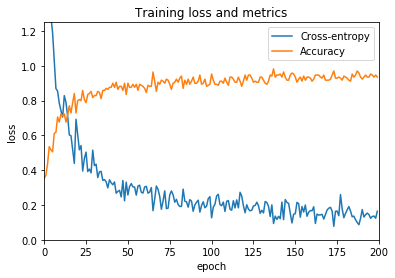

In [21]:
# print(history.history.keys())
# "Loss"
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('Training loss and metrics')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.axis([0, 200, 0, 1.25])
plt.legend(['Cross-entropy', 'Accuracy'], loc='upper right');

### Training error

In [12]:
NN_model.evaluate(sXtrain, ytrain)

print('\n Assessment of error: \n')
pred_train_prob = NN_model.predict(sXtrain)
pred_train = np.argmax(pred_train_prob, axis=1)
print(sklearn.metrics.classification_report(ytrain,pred_train))
print('Confusion:')
print(sklearn.metrics.confusion_matrix(ytrain,pred_train))
print('Predictions (prob):')
print(np.round(pred_train_prob[1:10,:],3))

170/170 [==============================] - 0s 451us/sample - loss: 0.0121 - accuracy: 1.0000

 Assessment of error: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        56
           2       1.00      1.00      1.00        57

    accuracy                           1.00       170
   macro avg       1.00      1.00      1.00       170
weighted avg       1.00      1.00      1.00       170

Confusion:
[[57  0  0]
 [ 0 56  0]
 [ 0  0 57]]
Predictions (prob):
[[0.    0.    1.   ]
 [0.    0.001 0.999]
 [0.005 0.995 0.   ]
 [1.    0.    0.   ]
 [1.    0.    0.   ]
 [0.    1.    0.   ]
 [0.001 0.981 0.019]
 [0.    1.    0.   ]
 [1.    0.    0.   ]]


### Test error

In [13]:
NN_model.evaluate(sXtest, ytest);

print('\n Assessment of error: \n')
pred_test_prob = NN_model.predict(sXtest)
pred_test = np.argmax(pred_test_prob, axis=1)
print(sklearn.metrics.classification_report(ytest,pred_test))
print('Confusion:')
print(sklearn.metrics.confusion_matrix(ytest,pred_test))
print('Predictions (prob):')
print(np.round(pred_test_prob[1:10,:],3))

43/43 [==============================] - 0s 147us/sample - loss: 0.0222 - accuracy: 0.9767

 Assessment of error: 

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.94      1.00      0.97        15
           2       1.00      1.00      1.00        14

    accuracy                           0.98        43
   macro avg       0.98      0.98      0.98        43
weighted avg       0.98      0.98      0.98        43

Confusion:
[[13  1  0]
 [ 0 15  0]
 [ 0  0 14]]
Predictions (prob):
[[0.    0.    1.   ]
 [0.    0.001 0.999]
 [0.    1.    0.   ]
 [0.    1.    0.   ]
 [1.    0.    0.   ]
 [1.    0.    0.   ]
 [1.    0.    0.   ]
 [1.    0.    0.   ]
 [1.    0.    0.   ]]


# Hyperparameter optimization

It gets tedious to find an "optimal" combination of the hyperparameters by hand, so in this section, we will explore how we can automate this process.

## Random search

In this section, we will use the random search implementation `RandomizedSearchCV` of the `sklearn` package to select a setting for the model hyperparameters, which we will take to be the number of hidden layers and neurons.

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

First, we define a model builder function for `RandomizedSearchCV`;

In [15]:
def model_opt(n_hidden=1, n_units=16, r_dropOut_hidden=.5, input_shape=[13]):
    model = keras.models.Sequential()

    # The Input Layer :
    model.add(InputLayer(input_shape=input_shape))
    model.add(Dropout(.2))
#     NN_model.add(BatchNormalization())

    # The Hidden Layers :
    for layer in range(n_hidden):
        model.add(Dense(n_units, kernel_initializer='he_normal',activation='relu'))
        model.add(Dropout(r_dropOut_hidden))
#         NN_model.add(BatchNormalization())

    # The Output Layer :
    model.add(Dense(3, kernel_initializer='he_normal',activation='softmax'))

    # Compile the network :
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return(model)

Second, we wrap the model for use with `sklearn` using the `KerasClassifier` function, define the search space, and perform the optimization. Note that this is a little time consuming even for this small example, and thus the optimization is pre-run, saved and loaded below (uncomment the content of the following two cells to re-run the optimization).

In [16]:
# estimators = []
# estimators.append(( 'scaler', sklearn.preprocessing.StandardScaler() ))
# estimators.append(( 'mlp', keras.wrappers.scikit_learn.KerasClassifier(model_opt) ))
# pipeline = Pipeline(estimators)

# hyper_param = {'mlp__n_hidden': (1,2,3),
#                'mlp__n_units': (8, 16, 32, 64, 128),
#                'mlp__r_dropOut_hidden': (.2, .3, .4, .5)
#               }

# rsCV = RandomizedSearchCV(pipeline, hyper_param, n_iter=10, cv=5, refit=True, random_state=42)
# rsCV.fit(Xtrain, ytrain, mlp__epochs=200, mlp__batch_size=8, mlp__callbacks=callbacks_list);

In [17]:
# print(rsCV.best_params_)
# optScaler = rsCV.best_estimator_['scaler'] # collect input scaler
# optModel = rsCV.best_estimator_['mlp'].model # collect model
# optModel.save('NNClas_optModel.h5')  # creates a HDF5 file 'NNClas_optModel.h5'
# pickle.dump(optScaler, open('NNClas_scaler.pkl', 'wb'))

In [18]:
optScaler = pickle.load(open('NNClas_scaler.pkl', 'rb'))
optModel = keras.models.load_model('NNClas_optModel.h5')
optModel.summary()

Model: "sequential_264"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_820 (Dropout)        (None, 13)                0         
_________________________________________________________________
dense_832 (Dense)            (None, 16)                224       
_________________________________________________________________
dropout_821 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_833 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_822 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_834 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_823 (Dropout)        (None, 16)             

### Training error

In [19]:
sXtrain_opt = optScaler.transform(Xtrain) # same as sXtrain (scaler trained on full training set in both cases)
optModel.evaluate(sXtrain_opt, ytrain)
print('\n Assessment of error: \n')
pred_train_prob_opt = optModel.predict(sXtrain_opt)
pred_train_opt = np.argmax(pred_train_prob_opt, axis=1)
print(sklearn.metrics.classification_report(ytrain,pred_train_opt))
print('Confusion:')
print(sklearn.metrics.confusion_matrix(ytrain,pred_train_opt))
print('Predictions (prob):')
print(np.round(pred_train_prob_opt[1:10,:],3))

170/170 [==============================] - 0s 462us/sample - loss: 0.0091 - accuracy: 1.0000

 Assessment of error: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        56
           2       1.00      1.00      1.00        57

    accuracy                           1.00       170
   macro avg       1.00      1.00      1.00       170
weighted avg       1.00      1.00      1.00       170

Confusion:
[[57  0  0]
 [ 0 56  0]
 [ 0  0 57]]
Predictions (prob):
[[0.    0.    1.   ]
 [0.    0.    1.   ]
 [0.    1.    0.   ]
 [1.    0.    0.   ]
 [1.    0.    0.   ]
 [0.    1.    0.   ]
 [0.012 0.974 0.014]
 [0.    1.    0.   ]
 [1.    0.    0.   ]]


### Test error

In [20]:
sXtest_opt = optScaler.transform(Xtest) # same as sXtest (scaler trained on full training set in both cases)
optModel.evaluate(sXtest_opt, ytest)
print('\n Assessment of error: \n')
pred_test_prob_opt = optModel.predict(sXtest_opt)
pred_test_opt = np.argmax(pred_test_prob_opt, axis=1)
print(sklearn.metrics.classification_report(ytest, pred_test_opt))
print('Confusion:')
print(sklearn.metrics.confusion_matrix(ytest ,pred_test_opt))
print('Predictions (prob):')
print(np.round(pred_test_prob_opt[1:10,:],3))

43/43 [==============================] - 0s 113us/sample - loss: 0.0108 - accuracy: 1.0000

 Assessment of error: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        14

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43

Confusion:
[[14  0  0]
 [ 0 15  0]
 [ 0  0 14]]
Predictions (prob):
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


This optimized model result in a perfect performance on both the training and test set.